In [1]:
pip install pyAudioAnalysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264372 sha256=1eaaf3cb420650fe99b43ed2a1127f2bde337378b60c54723dcbc67433ba4258
  Stored in directory: /root/.cache/pip/wheels/a7/54/73/fa830689c2440d2c81ff175c60e374930ad1607a8881e0f43f
Successfully built pyAudioAnalysis


In [2]:
pip install eyed3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 11.9 MB/s eta 0:00:00


In [3]:
pip install pydub

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
import subprocess

input_file = '/content/drive/My Drive/iLab/test.wav'
output_file = '/content/drive/My Drive/iLab/test_converted.wav'

subprocess.run(['ffmpeg', '-i', input_file, output_file])


CompletedProcess(args=['ffmpeg', '-i', '/content/drive/My Drive/iLab/test.wav', '/content/drive/My Drive/iLab/test_converted.wav'], returncode=1)

Text(0, 0.5, 'energy')

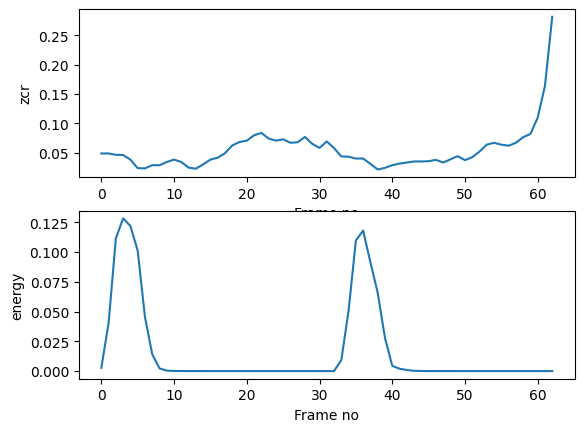

In [58]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt

# Load the audio file
[Fs, x] = audioBasicIO.read_audio_file('/content/drive/My Drive/iLab/test_converted.wav')

# Convert stereo to mono if necessary
if x.ndim > 1:  # Check if the audio has more than one channel (i.e., it's stereo)
    x = audioBasicIO.stereo_to_mono(x)

# Extract short-term features
F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.050*Fs, 0.025*Fs)

# Plot the extracted features
plt.subplot(2, 1, 1)
plt.plot(F[0, :])
plt.xlabel('Frame no')
plt.ylabel(f_names[0])

plt.subplot(2, 1, 2)
plt.plot(F[1, :])
plt.xlabel('Frame no')
plt.ylabel(f_names[1])

In [12]:
pip install numpy pandas librosa parselmouth


  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [14]:
pip install praat-parselmouth


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 69.3 MB/s eta 0:00:00


In [71]:
import numpy as np
import pandas as pd
import librosa
import parselmouth
from parselmouth.praat import call

# Load the audio file
file_path = '/content/drive/My Drive/iLab/test.wav'
y, sr = librosa.load(file_path, sr=None)

# Initialize an empty dictionary to hold the feature values
features = {}

# 1. MFCC and related features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

ordinal_names = ["0th", "1st", "2nd", "3rd"] + [f"{i}th" for i in range(4, 13)]

features.update({
    f'mean_MFCC_{ordinal_names[i]}_coef': np.mean(mfccs[i, :]) for i in range(13)
})
features.update({
    f'std_MFCC_{ordinal_names[i]}_coef': np.std(mfccs[i, :]) for i in range(13)
})
features.update({
    f'mean_{ordinal_names[i]}_delta': np.mean(delta_mfccs[i, :]) for i in range(13)
})
features.update({
    f'std_{ordinal_names[i]}_delta': np.std(delta_mfccs[i, :]) for i in range(13)
})

# Adjusting the naming convention for delta_delta features
features['mean_delta_delta_0th'] = np.mean(delta2_mfccs[0, :])
features['std_delta_delta_0th'] = np.std(delta2_mfccs[0, :])

features.update({
    f'mean_{ordinal_names[i]}_delta_delta': np.mean(delta2_mfccs[i, :]) for i in range(1, 13)
})
features.update({
    f'std_{ordinal_names[i]}_delta_delta': np.std(delta2_mfccs[i, :]) for i in range(1, 13)
})

# Log energy
log_energy = librosa.feature.rms(y=y)[0]
features['mean_Log_energy'] = np.mean(log_energy)
features['std_Log_energy'] = np.std(log_energy)
features['std_delta_delta_log_energy'] = np.std(np.diff(np.diff(log_energy)))

# Harmonicity (mean values)
sound = parselmouth.Sound(file_path)
harmonicity_cc = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
features['meanHarmToNoiseHarmonicity'] = call(harmonicity_cc, "Get mean", 0, 0)

# Intensity (min, max, mean)
intensity = call(sound, "To Intensity", 75, 0, "yes")
features['minIntensity'] = call(intensity, "Get minimum", 0, 0, "Parabolic")
features['maxIntensity'] = call(intensity, "Get maximum", 0, 0, "Parabolic")
features['meanIntensity'] = call(intensity, "Get mean", 0, 0)

# Convert to DataFrame
df_features = pd.DataFrame([features])

# Display the DataFrame
print(df_features.head())

# Save the DataFrame to a CSV file
output_file_path = '/content/drive/My Drive/iLab/extracted_features_general.csv'
df_features.to_csv(output_file_path, index=False)

# Output the file path for reference
print(f"DataFrame saved to: {output_file_path}")


   mean_MFCC_0th_coef  mean_MFCC_1st_coef  mean_MFCC_2nd_coef  \
0         -264.305908           68.656242          -29.679136   

   mean_MFCC_3rd_coef  mean_MFCC_4th_coef  mean_MFCC_5th_coef  \
0           35.448303            -22.6581            6.793788   

   mean_MFCC_6th_coef  mean_MFCC_7th_coef  mean_MFCC_8th_coef  \
0           -5.355618            1.453974           -4.827762   

   mean_MFCC_9th_coef  ...  std_10th_delta_delta  std_11th_delta_delta  \
0           13.624063  ...              0.750206              0.539734   

   std_12th_delta_delta  mean_Log_energy  std_Log_energy  \
0              0.600369         0.070054        0.074476   

   std_delta_delta_log_energy  meanHarmToNoiseHarmonicity  minIntensity  \
0                     0.00618                    4.708175        -300.0   

   maxIntensity  meanIntensity  
0     83.055145       62.03906  

[1 rows x 85 columns]
DataFrame saved to: /content/drive/My Drive/iLab/extracted_features_general.csv
